# Take 2 on your plate analyses
In this notebook I show some examples of how to use the "new and improved" interface for analysing your plates.
Instead of individual functions in a file, I have made a class called `Plate`, which represents one plate experiment.
This class comes with its own methods for getting the data into the desirable long format, visualizing the curves, doing curve fitting and
computing area under the curve. It also comes with functionality making it easy to add metadata to the DataFrames, and for adding two different `Plates` together.

In `models.py` a couple of curve fitting models can be found:
* `LogisticSymmetric`: A simple logistic function with (4 parameters)
* `Richards`: A generalized logistic function that allows for some asymmetry (5 parameters)
* `RichardsModified`: Default. A modified version of the `Richards` model (6 parameters)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

from plate import Plate
from models import LogisticSymmetric, Richards, RichardsModified

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# Creating a `Plate` object
The `Plate` class takes two mandatory arguments (in the following order):
* Path to a CSV file containing the plate layout
* Path to a CSV file containing the wide-form raw data

In addition, you can pass an `ID` which will be stored with the object, and added as metadata to the dataframes.

Several things take place when you create a `Plate`:
1. The template is congert to a DataFrame
2. The wide-form is converted to a DataFrame
3. A long-form version of the data is made as a second DataFrame
4. The replicates are combined into a third DataFrame

The wide-form DataFrame is not used as anything, except as a starting point. All analyses are done on the long-form and combined-form.

This is how you make a `Plate` object (using sample data):

In [2]:
template = 'Templates/Template_pseudomonas.csv'
wide = 'SampleData/Artificial1.csv'
plate = Plate(template, wide, blank_name='Blank', ID='SampleData1')

SampleData1


/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
plate.ID

'SampleData1'

# Retrieving the data

You can access the three DataFrames in the following way:
* `plate.wide`
* `plate.long`
* `plate.combined`

In [4]:
plate.wide.head()

,Time,Time_hours,Temp,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11
0,00:00:00,0.00,25.0,0.089088,0.002392,0.039860,0.008231,0.052974,0.064652,0.008767,0.009117,0.074929,0.019827,0.028621,0.080189,0.111411,0.103246,0.067677,0.017785,0.005729,0.095295,0.023014,0.011781,0.018424,0.027064,0.059325,0.002291,0.107041,0.110697,0.068444,0.050508,0.106884,0.069141,0.065262,0.088928,0.076220,0.067596,0.100549,0.018485,0.078920,0.108822,0.002614,0.095400,0.047934,0.055842,0.103298,0.105378,0.106321,0.071262,0.029555,0.076538,0.092469,0.051699,0.099473,0.103261,0.112607,0.052210,0.115785,0.048120,0.061985,0.114929,0.075102,0.082467
1,00:14:32,0.25,25.0,0.092928,0.002454,0.041246,0.008429,0.055382,0.067391,0.009083,0.009362,0.076936,0.020288,0.029394,0.082263,0.113152,0.105987,0.070010,0.018393,0.005880,0.098639,0.024247,0.011981,0.019088,0.027776,0.061336,0.002332,0.110969,0.114548,0.071394,0.052281,0.106884,0.070869,0.067513,0.091170,0.078158,0.069795,0.104810,0.019282,0.080269,0.113595,0.002679,0.096188,0.049195,0.056822,0.106041,0.107120,0.110052,0.073637,0.030065,0.077917,0.094050,0.052970,0.103724,0.106703,0.115545,0.053965,0.118564,0.048902,0.063602,0.116894,0.077061,0.083155
2,00:29:35,0.50,25.1,0.094464,0.002495,0.041940,0.008495,0.056345,0.068487,0.009083,0.009362,0.077605,0.020595,0.029910,0.083645,0.114022,0.108728,0.071177,0.018849,0.006030,0.100311,0.024864,0.012080,0.019420,0.028251,0.062341,0.002393,0.111951,0.115510,0.073164,0.053610,0.108622,0.072022,0.069763,0.092664,0.079450,0.070344,0.106514,0.019601,0.082967,0.115504,0.002700,0.096976,0.051298,0.059761,0.111526,0.108862,0.113782,0.076013,0.030319,0.078607,0.094840,0.053818,0.105424,0.108424,0.117503,0.054404,0.120417,0.050076,0.063602,0.117876,0.077061,0.084529
3,00:44:38,0.75,25.3,0.096768,0.002537,0.042633,0.008561,0.057308,0.069583,0.009162,0.009524,0.078274,0.020903,0.030426,0.085028,0.114893,0.111469,0.072344,0.019153,0.006081,0.101147,0.025274,0.012280,0.019586,0.028726,0.063347,0.002434,0.113915,0.118398,0.073754,0.054496,0.109491,0.073174,0.069201,0.094159,0.080096,0.071443,0.108218,0.019920,0.089712,0.120277,0.002700,0.098553,0.052139,0.060251,0.111526,0.110604,0.115648,0.077201,0.030829,0.079297,0.095630,0.054666,0.107124,0.111866,0.119462,0.055720,0.122269,0.050467,0.064141,0.117876,0.077714,0.085904
4,00:59:41,1.00,25.5,0.098304,0.002598,0.043326,0.008692,0.058272,0.070679,0.009320,0.009606,0.078943,0.021364,0.031199,0.086411,0.116634,0.114211,0.073511,0.019305,0.006332,0.104491,0.025891,0.012480,0.020084,0.029201,0.064855,0.002536,0.116861,0.119361,0.075524,0.054939,0.112967,0.074902,0.071451,0.095653,0.081388,0.074741,0.109922,0.020398,0.115344,0.144141,0.002721,0.100130,0.052559,0.060741,0.114268,0.113216,0.118446,0.078388,0.031339,0.080676,0.094840,0.056361,0.109675,0.114447,0.122399,0.057036,0.124122,0.051249,0.064680,0.119841,0.077714,0.087278


In [5]:
plate.long.head()

,Time_hours,Temp,Well,Absorption,Group,ID
0,0.00,25.0,B2,0.089088,Glucose,SampleData1
1,0.25,25.0,B2,0.092928,Glucose,SampleData1
2,0.50,25.1,B2,0.094464,Glucose,SampleData1
3,0.75,25.3,B2,0.096768,Glucose,SampleData1
4,1.00,25.5,B2,0.098304,Glucose,SampleData1


In [6]:
plate.combined.head()

,Group,Time_hours,Temp_Mean,Mean,Temp_StDev,StDev,logMean,logStDevUpper,logStDevLower,ID
0,Arabinose,0.00,25.0,0.062903,0.0,0.042930,-3.990738,-3.240140,-5.645865,SampleData1
1,Arabinose,0.25,25.0,0.064797,0.0,0.044029,-3.947934,-3.199902,-5.589539,SampleData1
2,Arabinose,0.50,25.1,0.066251,0.0,0.045142,-3.915905,-3.166266,-5.565959,SampleData1
3,Arabinose,0.75,25.3,0.067655,0.0,0.046337,-3.885651,-3.132996,-5.551731,SampleData1
4,Arabinose,1.00,25.5,0.069009,0.0,0.047613,-3.857078,-3.100095,-5.546522,SampleData1


Additionally, you can extract x and y data easily from a sub-group of the combined DataFrame like shown below.
You can get either the log-transformed mean values, or the un-transformed mean values.

In [7]:
x, y = plate.get_xy('Glucose', log=False)
# x, y = plate.get_xy('Glucose', log=True)

In [8]:
x.head()

1544    0.00
1545    0.25
1546    0.50
1547    0.75
1548    1.00
Name: Time_hours, dtype: float64

In [9]:
y.head()

1544    0.043780
1545    0.045543
1546    0.046300
1547    0.047312
1548    0.048076
Name: Mean, dtype: float64

# Adding metadata
If you want to add metadata to the long and combined DataFrames, you can use the `add_metadata` method.
The first argument is the column name, and the second argument is the value.
The value is always added to all rows.

There is also a method for removing metadata: `remove_metadata(Parametername)`. The column matching
`Parametername` will be dropped inplace.

In [10]:
plate.add_metadata('Parameter1', 'Value1')

In [11]:
plate.long.head()

,Time_hours,Temp,Well,Absorption,Group,ID,Parameter1
0,0.00,25.0,B2,0.089088,Glucose,SampleData1,Value1
1,0.25,25.0,B2,0.092928,Glucose,SampleData1,Value1
2,0.50,25.1,B2,0.094464,Glucose,SampleData1,Value1
3,0.75,25.3,B2,0.096768,Glucose,SampleData1,Value1
4,1.00,25.5,B2,0.098304,Glucose,SampleData1,Value1


In [12]:
plate.combined.head()

,Group,Time_hours,Temp_Mean,Mean,Temp_StDev,StDev,logMean,logStDevUpper,logStDevLower,ID,Parameter1
0,Arabinose,0.00,25.0,0.062903,0.0,0.042930,-3.990738,-3.240140,-5.645865,SampleData1,Value1
1,Arabinose,0.25,25.0,0.064797,0.0,0.044029,-3.947934,-3.199902,-5.589539,SampleData1,Value1
2,Arabinose,0.50,25.1,0.066251,0.0,0.045142,-3.915905,-3.166266,-5.565959,SampleData1,Value1
3,Arabinose,0.75,25.3,0.067655,0.0,0.046337,-3.885651,-3.132996,-5.551731,SampleData1,Value1
4,Arabinose,1.00,25.5,0.069009,0.0,0.047613,-3.857078,-3.100095,-5.546522,SampleData1,Value1


In [13]:
plate.remove_metadata('Parameter1')
plate.combined.head()

,Group,Time_hours,Temp_Mean,Mean,Temp_StDev,StDev,logMean,logStDevUpper,logStDevLower,ID
0,Arabinose,0.00,25.0,0.062903,0.0,0.042930,-3.990738,-3.240140,-5.645865,SampleData1
1,Arabinose,0.25,25.0,0.064797,0.0,0.044029,-3.947934,-3.199902,-5.589539,SampleData1
2,Arabinose,0.50,25.1,0.066251,0.0,0.045142,-3.915905,-3.166266,-5.565959,SampleData1
3,Arabinose,0.75,25.3,0.067655,0.0,0.046337,-3.885651,-3.132996,-5.551731,SampleData1
4,Arabinose,1.00,25.5,0.069009,0.0,0.047613,-3.857078,-3.100095,-5.546522,SampleData1


# Making graphs
Several graphing methods are implemented:
* `show()`: Visualize the plate layout
* `show_all_curves()`: Plot growth curves for all wells
* `show_combined_curves()`: Plot the means after combining replicates
* `show_fitted_curve()`: Make a fit on specified group and display original data overlayed with fit
* `show_fitted_curves()`: Same as above, but perform fit for all curves and display in a grid.
* `show_temperatures()`: Make a scatterplot of the temperatures throughout the experiment.

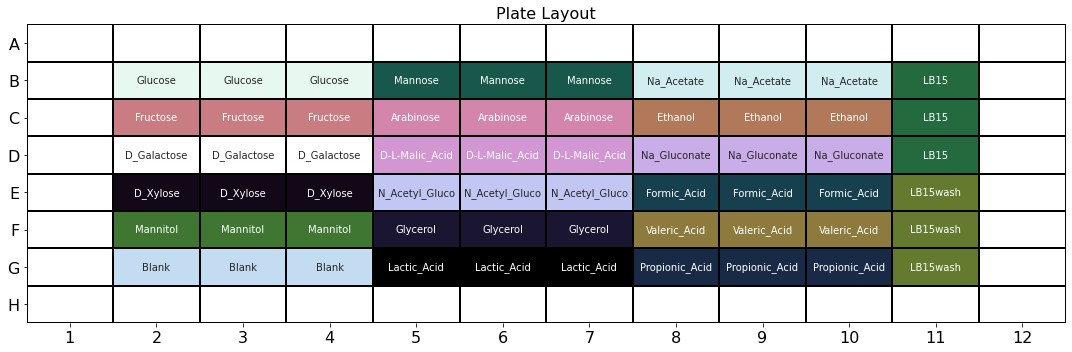

In [14]:
plate.show()

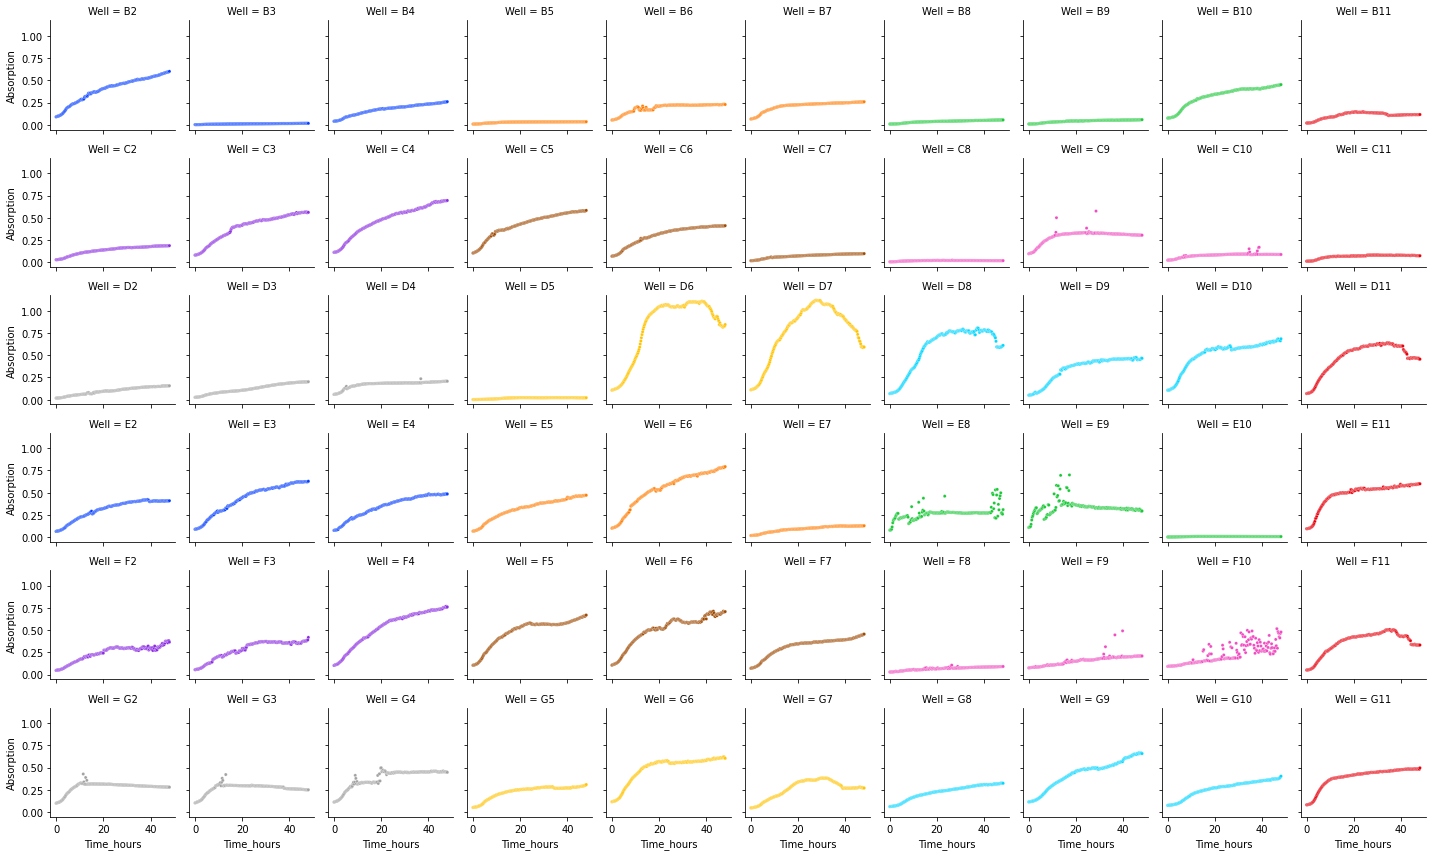

In [15]:
plate.show_all_curves()

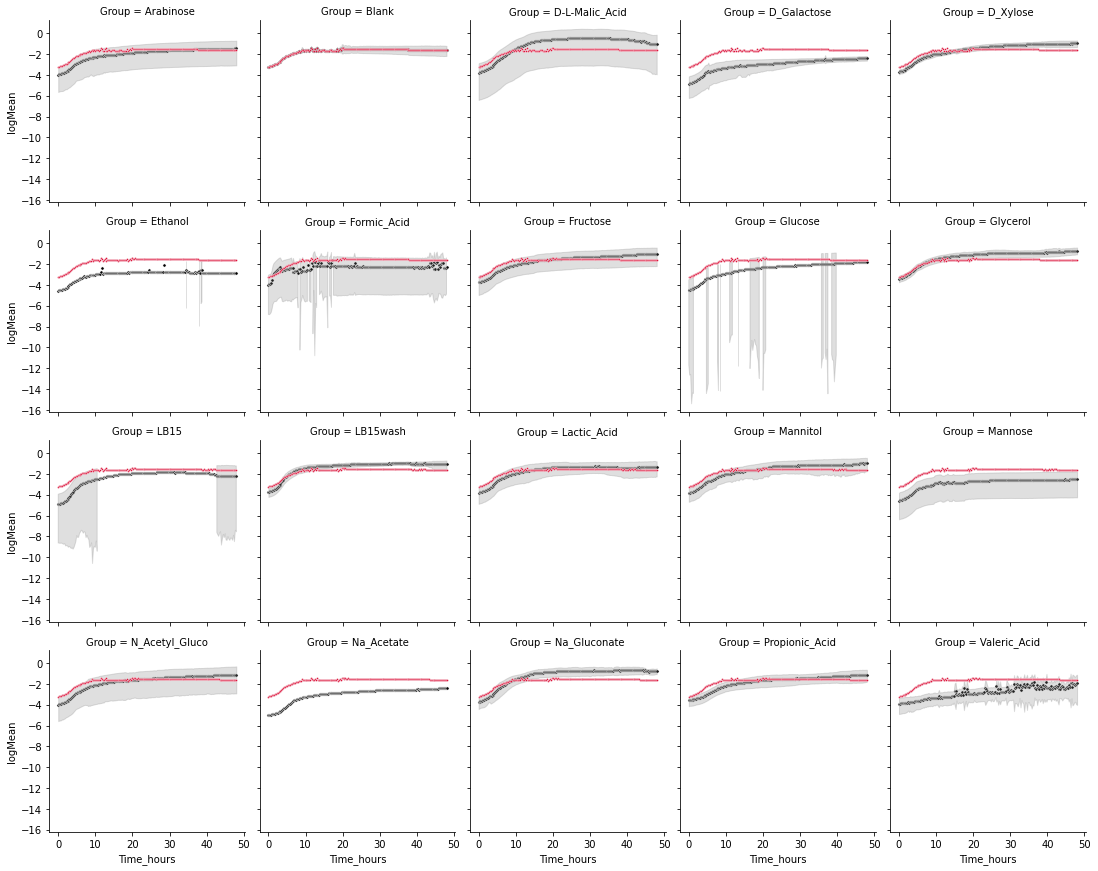

In [16]:
plate.show_combined_curves()

(<models.RichardsModified at 0x7f97f2571430>,
 <AxesSubplot:xlabel='Time_hours', ylabel='logMean'>)

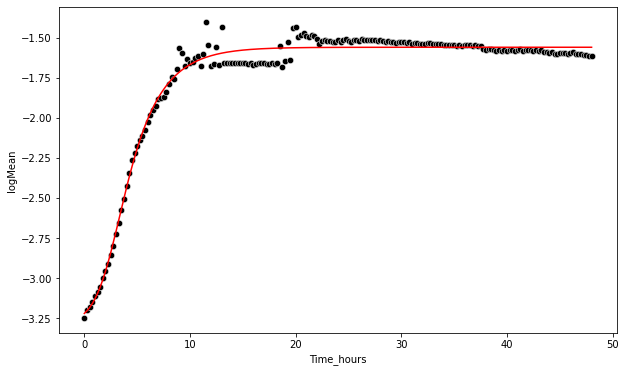

In [17]:
plate.show_fitted_curve(group='Blank')

/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


({'Lactic_Acid': <models.RichardsModified at 0x7f97f2d3e8e0>,
  'D_Xylose': <models.RichardsModified at 0x7f97f35a4c70>,
  'Glycerol': <models.RichardsModified at 0x7f97f3588d00>,
  'Propionic_Acid': <models.RichardsModified at 0x7f97f35afd90>,
  'Formic_Acid': <models.RichardsModified at 0x7f97f35b1850>,
  'Mannose': <models.RichardsModified at 0x7f97f35b7700>,
  'LB15': <models.RichardsModified at 0x7f97f35b8f10>,
  'Mannitol': <models.RichardsModified at 0x7f97f35b8c70>,
  'LB15wash': <models.RichardsModified at 0x7f97f35b9730>,
  'Valeric_Acid': <models.RichardsModified at 0x7f97f35b90a0>,
  'Ethanol': <models.RichardsModified at 0x7f97f35b91f0>,
  'Fructose': <models.RichardsModified at 0x7f97f35b9a60>,
  'Arabinose': <models.RichardsModified at 0x7f97f35b9910>,
  'D-L-Malic_Acid': <models.RichardsModified at 0x7f97f35b9dc0>,
  'Na_Gluconate': <models.RichardsModified at 0x7f97f35b9c40>,
  'N_Acetyl_Gluco': <models.RichardsModified at 0x7f97f35b99a0>,
  'Blank': <models.RichardsMo

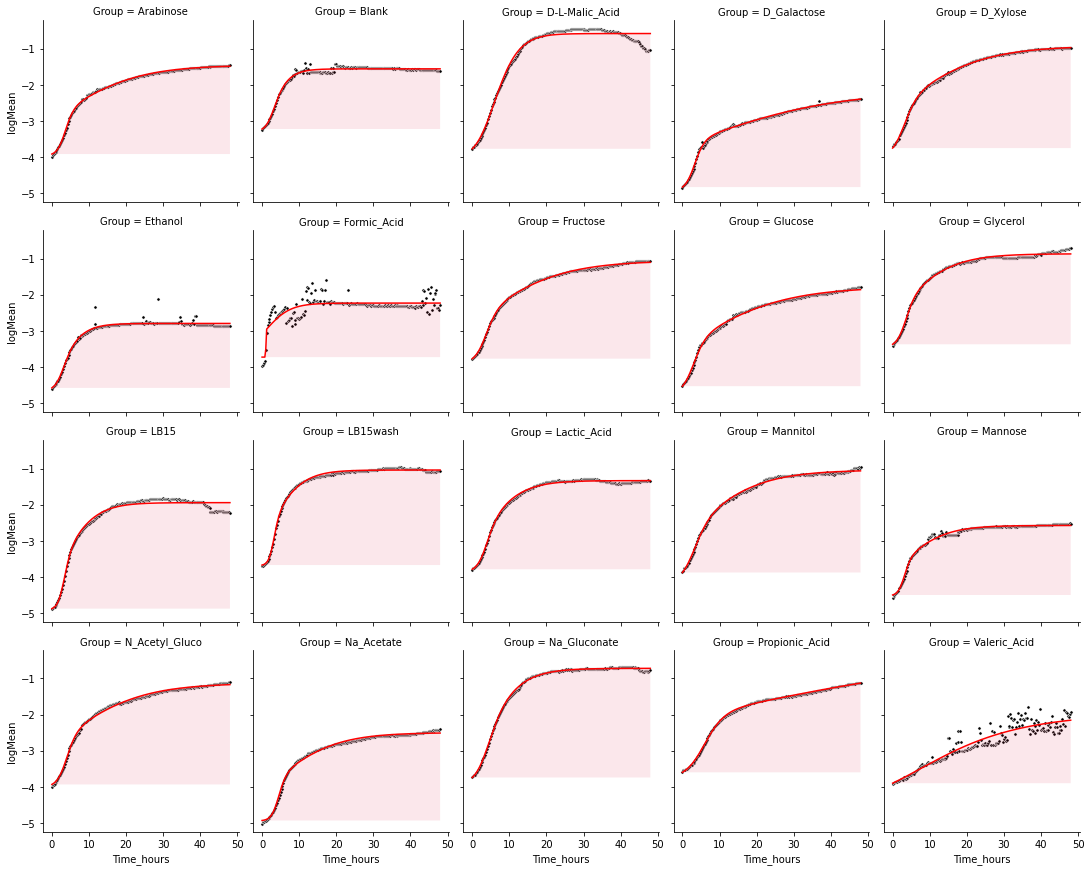

In [18]:
plate.show_fitted_curves()

<AxesSubplot:title={'center':'Temperatures'}, xlabel='Time_hours', ylabel='Temp_Mean'>

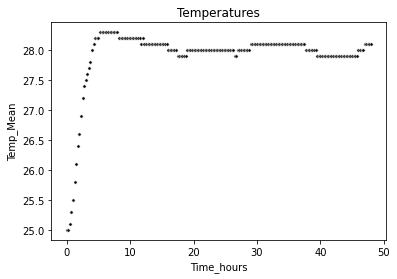

In [19]:
plate.show_temperatures()

# Fitting models
You can also fit models without plotting, both on a single group or on the whole plate, using the `fit_model()` method.
You must give a model name mathing either
* logisticsymmetric
* richards
* richardsmodified (default if not model name is given)

This method returns a `models` object, as defined in the corresponding model class located in `models.py`.
With this object you can extract useful information from the fitted model.

**Beware**: Currently, all model fitting can only be done on the log-transformed data.

In [20]:
model = plate.fit_model(group='Glycerol', modelname='richardsmodified')

### Symbolic representations

In [21]:
model.symbolic_function()

L + (1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)

In [22]:
model.symbolic_first_derivative()

k1*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k1*(x - x0))/(v*(1 + exp(-k1*(x - x0)))) + k2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k2*(x - x0))/(v*(1 + exp(-k2*(x - x0))))

In [23]:
model.symbolic_second_derivative()

-k1**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k1*(x - x0))/(v*(1 + exp(-k1*(x - x0)))) + k1**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-2*k1*(x - x0))/(v*(1 + exp(-k1*(x - x0)))**2) + k1**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-2*k1*(x - x0))/(v**2*(1 + exp(-k1*(x - x0)))**2) + 2*k1*k2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k1*(x - x0))*exp(-k2*(x - x0))/(v**2*(1 + exp(-k1*(x - x0)))*(1 + exp(-k2*(x - x0)))) - k2**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k2*(x - x0))/(v*(1 + exp(-k2*(x - x0)))) + k2**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-2*k2*(x - x0))/(v*(1 + exp(-k2*(x - x0)))**2) + k2**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-2*k2*(x - x0))/(v**2*(1 + exp(-k2*(x - x0)))**2)

### Data that the model is based on

In [24]:
model.x.head()

1737    0.00
1738    0.25
1739    0.50
1740    0.75
1741    1.00
Name: Time_hours, dtype: float64

In [25]:
model.y.head()

1737   -3.406284
1738   -3.366817
1739   -3.328400
1740   -3.305422
1741   -3.274388
Name: logMean, dtype: float64

### Maximum growth rate

In [26]:
model.max_growth_rate()

0.3387234565817965

### Area under the curve
Note that the implementation is not simply the integral of the function from $a$ to $b$.
The area is computed as (with $f(x)$ being the model function)

$$
A = (b - a) \min(f(a)) - \int_a^b f(x) dx
$$

This is in order to get a more intuitive estimate of the area, and in this way the area corresponds to the shaded area shown in the fitted curves above.

In [27]:
model.area_under_curve()

101.16875040627167

### Optimized model parameters

In [28]:
model.popt

(-0.5686017897075544,
 -3.4459298104063416,
 0.14659480243521364,
 0.7789558953048498,
 0.9466697047904907,
 3.176432914667927)

### Fitting on a full plate
Not specifying a group means a model will be fitted to all groups, and a dictionary of `group: model` is returned.
You can iterate over the dictionary to, for example, get out the areas for plotting.

In [29]:
models = plate.fit_model()

/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/abr121/Documents/dev/Mikkel/models.py:124: RuntimeWarning: overflow encountered in exp
  return L + ( (U - L)/ ((1 + np.exp(-k1*(x-x0)))**1/v * (1 + np.exp(-k2*(x-x0)))**1/v) )


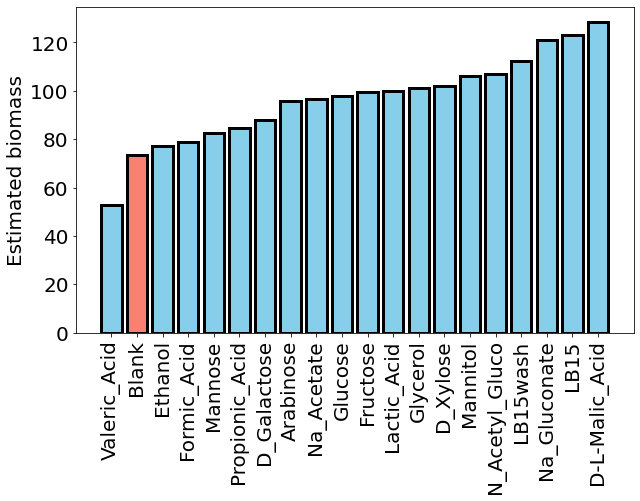

In [30]:
FS = 20
fig, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='x', labelrotation=90, labelsize=FS)
ax.tick_params(axis='y', labelsize=FS)
ax.set_ylabel('Estimated biomass', fontsize=FS)

areas = []
for group, model in sorted(models.items()):
    areas.append((group, model.area_under_curve()))

for g, a in sorted(areas, key=lambda x: x[-1]):
    color = 'skyblue' if g != 'Blank' else 'salmon'
    ax.bar(g, a, color=color, edgecolor='black', lw=3)

# Performing a batch analyis
Lastly, the `analyze()` method can be used to go through all the plots and analyses in one go, and just print the results.
Perhaps this can be a quick way of summarizing the plate data.

`savefiles=True` will save all figures as PNGs and all displayed dataframes as CSVs.

Fitting models


/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Computing areas and rates


/Users/abr121/Documents/dev/Mikkel/models.py:124: RuntimeWarning: overflow encountered in exp
  return L + ( (U - L)/ ((1 + np.exp(-k1*(x-x0)))**1/v * (1 + np.exp(-k2*(x-x0)))**1/v) )
/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             Group         U         L        k1          k2         v            x0
0      Lactic_Acid -1.117139 -3.858982  0.193046    0.703273  0.959577  3.375562e+00
1         D_Xylose -1.068938 -3.982126  0.091528    0.576080  1.024945  2.700280e+00
2         Glycerol -0.568602 -3.445930  0.146595    0.778956  0.946670  3.176433e+00
3   Propionic_Acid -1.557500 -3.766855  0.024519    0.383129  1.271693  5.646946e+00
4      Formic_Acid -1.222271 -3.723780  0.305537  911.821143  0.772719  1.001037e+00
5          Mannose -2.516724 -4.520522  0.174656    1.135292  0.985671  2.956378e+00
6             LB15 -1.798435 -4.909997  1.054827    0.222562  0.976422  3.083873e+00
7         Mannitol -0.987644 -4.155148  0.509963    0.107900  0.991359  2.608020e+00
8         LB15wash -1.063244 -3.684519  0.237475    1.320869  1.004111  3.026794e+00
9     Valeric_Acid -1.820410 -4.543905  0.097045    0.054180  0.975352  1.787277e-08
10         Ethanol -2.025869 -4.651711  0.294496    0.777024  0.8

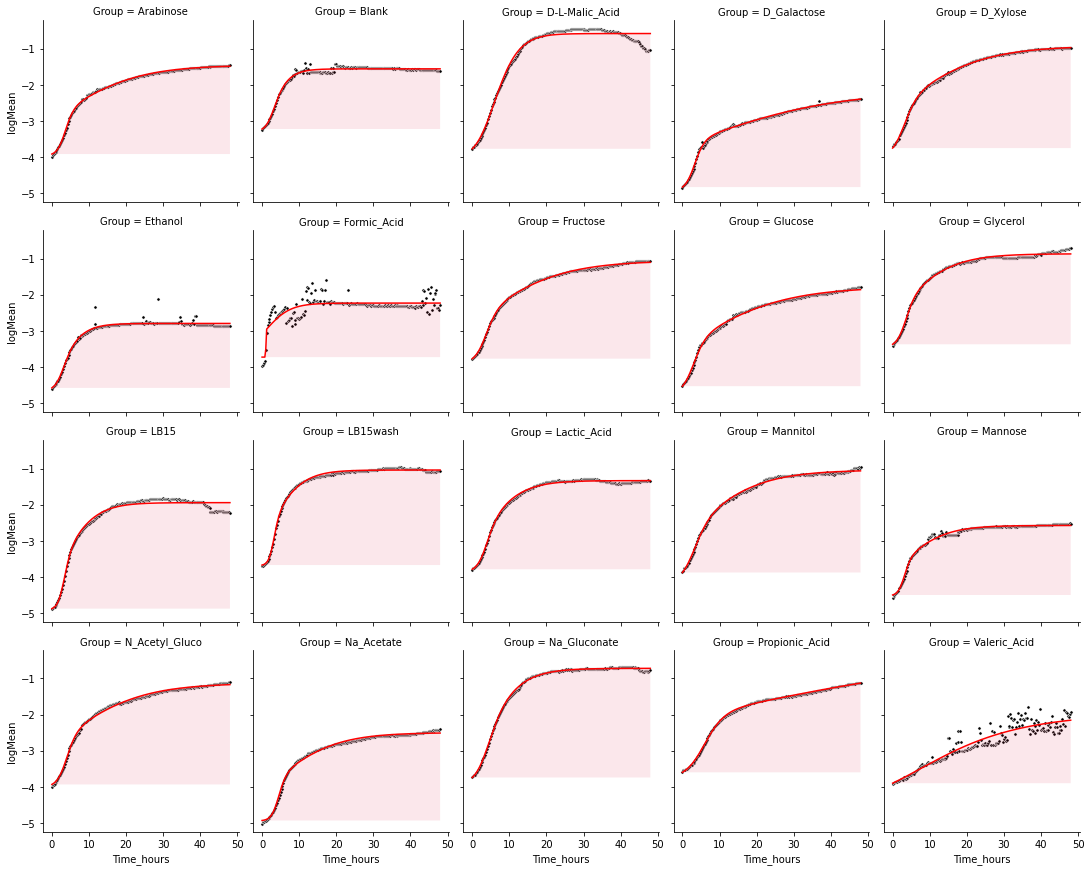

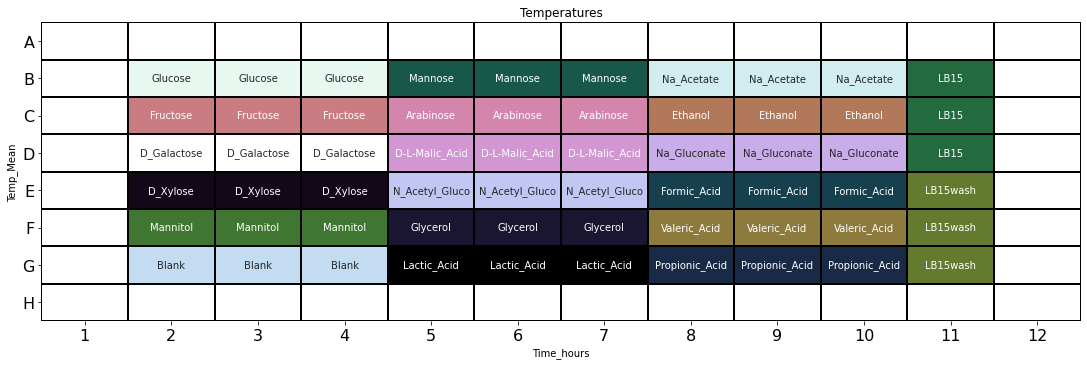

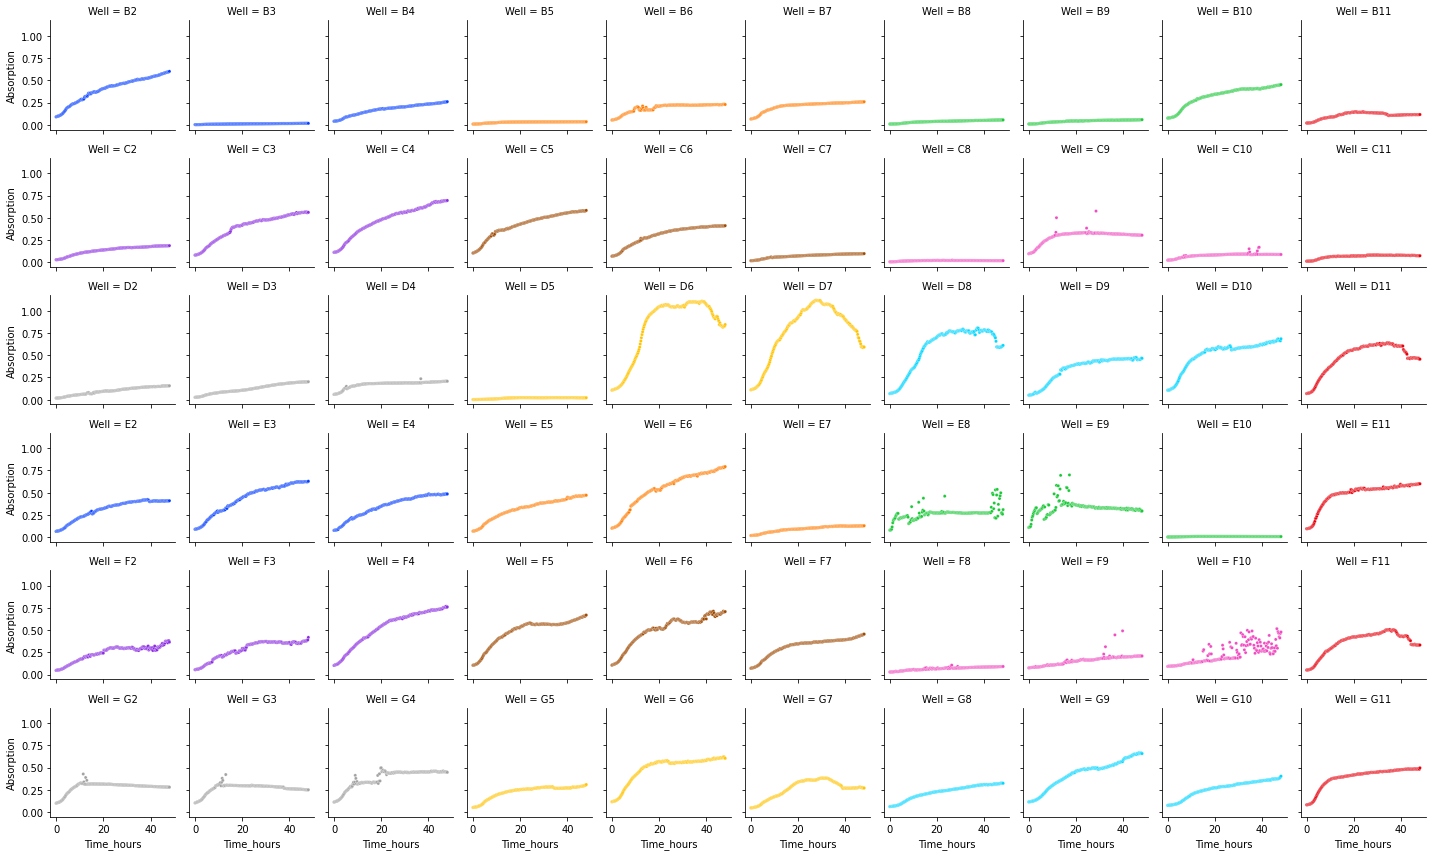

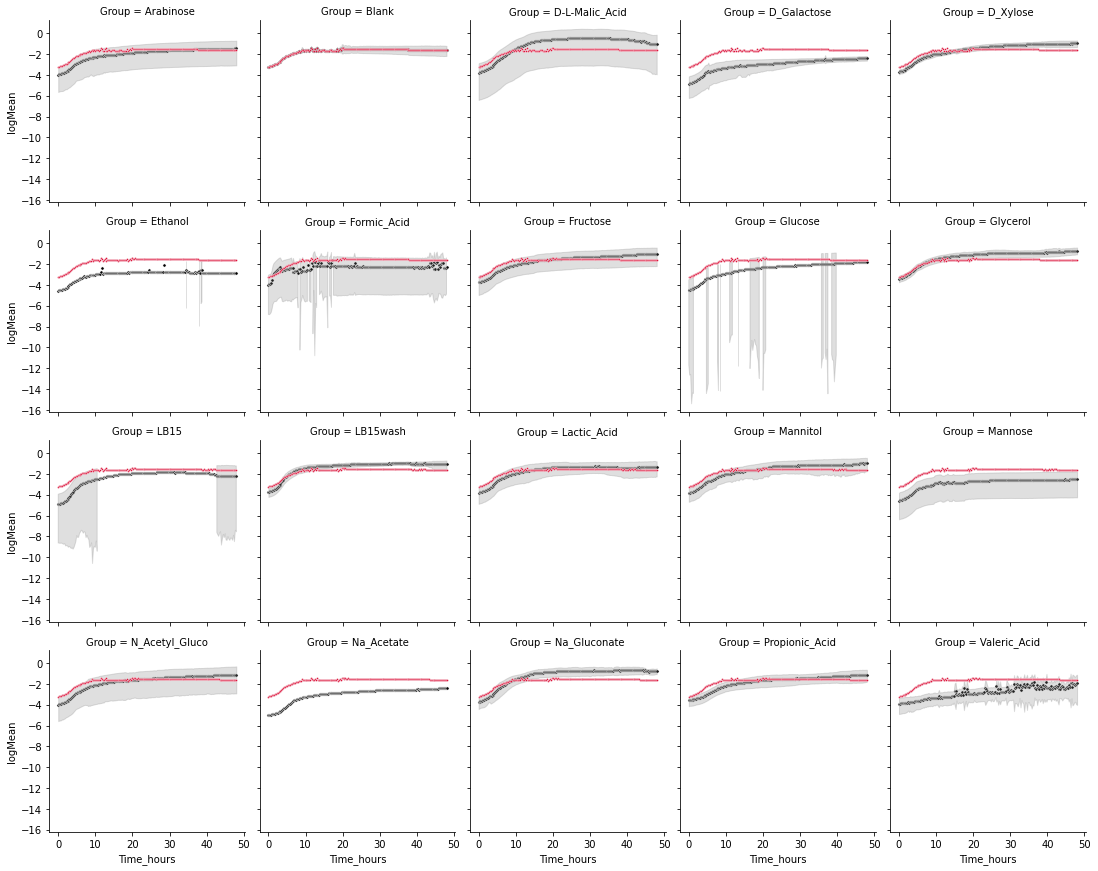

In [31]:
plate.analyze(savefiles=False)

# Combining multiple `Plates`
The `__add__` function in the class definition makes it easy to add two plates together.
What happens is that the `long` DataFrames for each `Plate` are concatenated, and the `combined` for each `Plate` are concatenated. 
These concatenated DataFrames are returned as a tuple.
Notice that the `ID`s passed to each plate are carried over to the concatenated ones.

**Note**: There must be the same number of columns in each DataFrame for this to work properly, so it will fail it you have added additional metadata to one Plate but not the other.

**Note**: Only `Pandas.DataFrame`s are returned when adding, and so all the functionality from the `Plate` class is lost.

**Note**: The group names in the two template files have to match *exactly* for `Seaborn` to "hue-match" correctly.

In [32]:
# Make a new Plate
template = 'Templates/Template_pseudomonas.csv'
wide = 'SampleData/Artificial2.csv'
plate2 = Plate(template, wide, blank_name='Blank', ID='SampleData2')

SampleData2


/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
combined_plate = plate + plate2

SampleData1+SampleData2


In [34]:
combined_plate.long

,Time_hours,Temp,Well,Absorption,Group,ID
0,0.00,25.0,B2,0.089088,Glucose,SampleData1
1,0.25,25.0,B2,0.092928,Glucose,SampleData1
2,0.50,25.1,B2,0.094464,Glucose,SampleData1
3,0.75,25.3,B2,0.096768,Glucose,SampleData1
4,1.00,25.5,B2,0.098304,Glucose,SampleData1
...,...,...,...,...,...,...
11575,47.00,28.1,G11,0.674370,LB15wash,SampleData2
11576,47.25,28.1,G11,0.679166,LB15wash,SampleData2
11577,47.50,28.1,G11,0.683963,LB15wash,SampleData2
11578,47.75,28.1,G11,0.672451,LB15wash,SampleData2


In [35]:
combined_plate.combined

,Group,Time_hours,Temp_Mean,Mean,Temp_StDev,StDev,logMean,logStDevUpper,logStDevLower,ID
0,Arabinose,0.00,25.0,0.062903,0.0,0.042930,-3.990738,-3.240140,-5.645865,SampleData1
1,Arabinose,0.25,25.0,0.064797,0.0,0.044029,-3.947934,-3.199902,-5.589539,SampleData1
2,Arabinose,0.50,25.1,0.066251,0.0,0.045142,-3.915905,-3.166266,-5.565959,SampleData1
3,Arabinose,0.75,25.3,0.067655,0.0,0.046337,-3.885651,-3.132996,-5.551731,SampleData1
4,Arabinose,1.00,25.5,0.069009,0.0,0.047613,-3.857078,-3.100095,-5.546522,SampleData1
...,...,...,...,...,...,...,...,...,...,...
3855,Valeric_Acid,47.00,28.1,0.195192,0.0,0.116058,-2.357031,-1.683851,-3.659558,SampleData2
3856,Valeric_Acid,47.25,28.1,0.188301,0.0,0.111894,-2.408887,-1.736026,-3.710156,SampleData2
3857,Valeric_Acid,47.50,28.1,0.186370,0.0,0.110915,-2.423756,-1.750079,-3.728238,SampleData2
3858,Valeric_Acid,47.75,28.1,0.194821,0.0,0.115641,-2.359779,-1.687509,-3.658728,SampleData2


### Looking at the differences between the two plates

SampleData1+SampleData2


(<seaborn.axisgrid.FacetGrid at 0x7f97f9b03130>,
 <plate.Plate at 0x7f97f374ab80>)

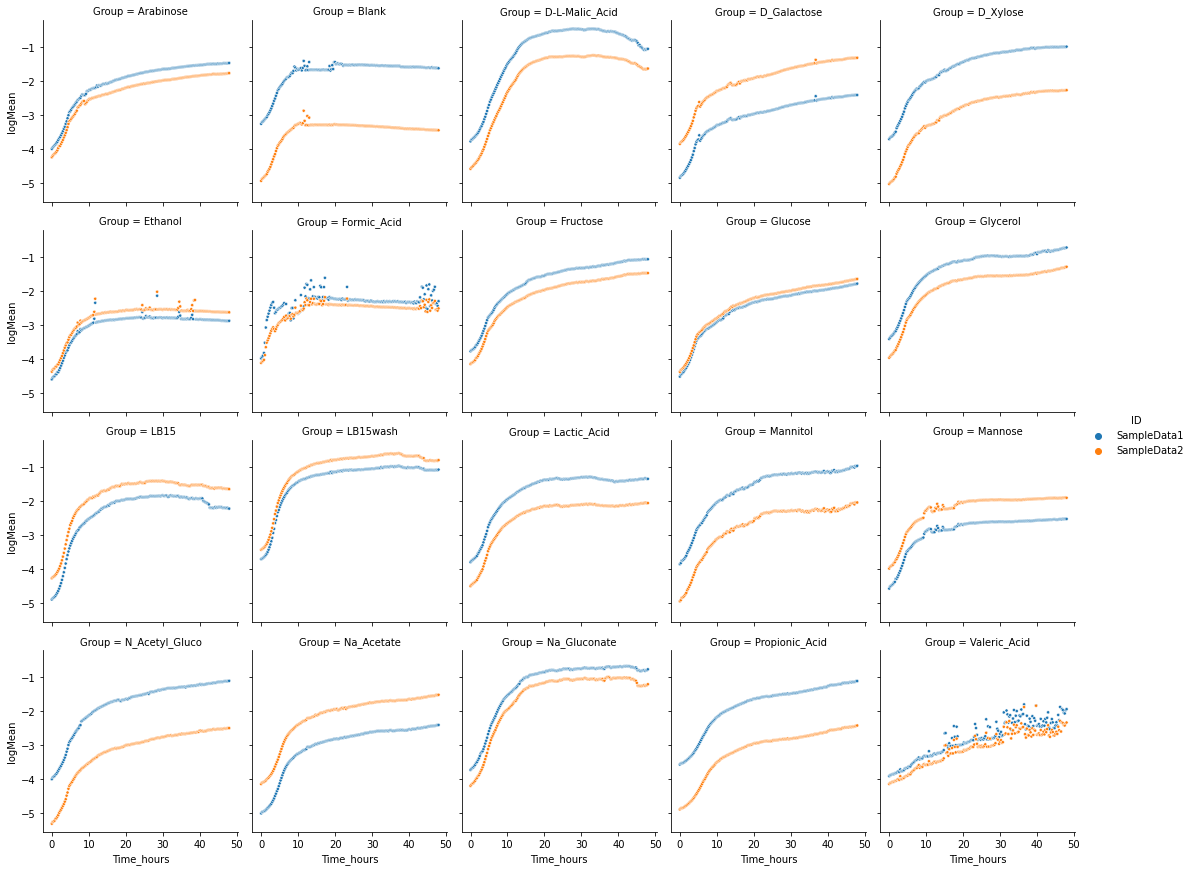

In [36]:
plate.show_comparison_to(plate2)